<a href="https://colab.research.google.com/github/shpark02084/TensorFlow/blob/main/computer_vision_food_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try to build a deep learning model to beat the original Food-101 Mining Discriminative Components with Random Forests, 50.67% accuracy. \\
[Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) 


|  | 🍔👁 Food Vision|
|-----|-----|
| Dataset source | TensorFlow Datasets | 
| Train data | 75,750 images | 
| Test data | 25,250 images | 
| Data loading | Performanant tf.data API | 
| Target results |   50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 



Following steps


1.   Using TensorFlow Datasets to download and explore data
2.   Creating preprocessing function for our data
3.   Batching & preparing datasets for modelling
4. Creating modelling callbakcs
5. Setting up mixed precision training
6. Building a Fine-tuning the feature extraction model





In [1]:
# Check GPU
!nvidia-smi 
import tensorflow as tf 


Sat Apr 30 19:20:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get functions

!wget https://raw.githubusercontent.com/shpark02084/helper_function/main/functions.py


--2022-04-30 19:21:01--  https://raw.githubusercontent.com/shpark02084/helper_function/main/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-30 19:21:02 (69.1 MB/s) - ‘functions.py’ saved [10246/10246]



## **1. Using TensorFlow Datasets to download and explore data**

In [3]:
#import functions
from functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# Load food101 data
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True)
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteC3XA0D/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteC3XA0D/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
# Get data info 
ds_info.features



FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get first 10 class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
# What does one sample of our training data look like?
train_one_sample
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        


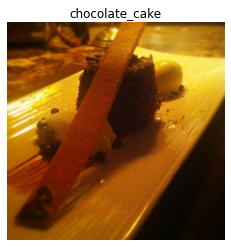

In [9]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## **2. Creating preprocessing function for our data**

In [10]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label 

In [11]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[32 14  0]
  [31 13  0]
  [28 12  0]
  ...
  [54 34 10]
  [53 33  9]
  [51 31  7]]

 [[28 10  0]
  [28 10  0]
  [27 11  0]
  ...
  [56 36 12]
  [55 35 11]
  [54 34  9]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[29.19898    11.198979    0.        ]
  [28.285715   12.285714    0.        ]
  [30.852041   15.494898    0.28061217]
  ...
  [52.9336     32.505074    8.7193365 ]
  [54.025528   34.025528   10.025528  ]
  [53.800972   33.800972    9.571359  ]]

 [[33.09694    15.096939    1.193878  ]
  [33.785713   17.785715    2.785715  ]
  [31.785713   16.428572    1.2142859 ]
  ...
  [63.60206    42.530632   15.346998  ]
  [61.647934   40.7857     13.928558  ]
  [60.785713   41.714287   12.020403  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


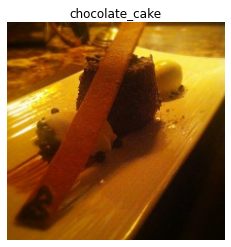

In [12]:
# Plot preprocessed image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## **3. Batching & preparing datasets for modelling**

In [13]:
# 
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## **4. Creating modelling callbakcs**

In [14]:
# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", 
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1) 

## **5. Setting up mixed precision training**

In [15]:
# Mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

## **6. Building a fine-tuning and feature extraction model**

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False 


inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)

x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [17]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [18]:
# Fit
history_feature_extract = model.fit(train_data, 
                                    epochs=3,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", 
                                                                          "efficientnetb0_101_classes_all_data_feature_extract"),
                                    model_checkpoint])


Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220430-192940
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8223 - accuracy: 0.5568
Epoch 1: val_loss improved from inf to 1.22386, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 183s 70ms/step - loss: 1.8223 - accuracy: 0.5568 - val_loss: 1.2239 - val_accuracy: 0.6809
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2935 - accuracy: 0.6661
Epoch 2: val_loss improved from 1.22386 to 1.12014, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 166s 70ms/step - loss: 1.2935 - accuracy: 0.6660 - val_loss: 1.1201 - val_accuracy: 0.7066
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1424 - accuracy: 0.7028
Epoch 3: val_loss improved from 1.12014 to 1.09164, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] -

In [19]:
# Evaluate 
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 61ms/step - loss: 1.0911 - accuracy: 0.7048


[1.0911118984222412, 0.704752504825592]

Load and Evaluate checkpoint weights

1.   Cloning the model
2.   load_weights()
3. evaluate()



In [20]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [21]:
!ls model_checkpoints/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [22]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [23]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [24]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [25]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 50s 60ms/step - loss: 1.7328 - accuracy: 0.5517


In [26]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision/assets


Add more callbacks


In [27]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [28]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [29]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(0.0001), 
                        metrics=["accuracy"])

In [30]:
# Fine tune model
all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, 
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), 
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, 
                                                                   early_stopping,
                                                                   reduce_lr]) 

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220430-194304
Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9714 - accuracy: 0.7517INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 246s 100ms/step - loss: 0.9714 - accuracy: 0.7517 - val_loss: 1.0485 - val_accuracy: 0.7193 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9542 - accuracy: 0.7573INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 235s 99ms/step - loss: 0.9542 - accuracy: 0.7573 - val_loss: 1.0454 - val_accuracy: 0.7198 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 179s 75ms/step - loss: 0.9431 - accuracy: 0.7610 - val_loss: 1.0468 - val_accuracy: 0.7190 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9338 - accuracy: 0.7628
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 165s 69ms/step - loss: 0.9338 - accuracy: 0.7628 - val_loss: 1.0464 - val_accuracy: 0.7177 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9165 - accuracy: 0.7689INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 214s 90ms/step - loss: 0.9165 - accuracy: 0.7689 - val_loss: 1.0401 - val_accuracy: 0.7217 - lr: 2.0000e-05
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9143 - accuracy: 0.7692INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 212s 89ms/step - loss: 0.9144 - accuracy: 0.7691 - val_loss: 1.0395 - val_accuracy: 0.7222 - lr: 2.0000e-05
Epoch 7/100
2368/2368 [==============================] - 161s 67ms/step - loss: 0.9125 - accuracy: 0.7697 - val_loss: 1.0419 - val_accuracy: 0.7201 - lr: 2.0000e-05
Epoch 8/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9109 - accuracy: 0.7698
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 164s 68ms/step - loss: 0.9108 - accuracy: 0.7698 - val_loss: 1.0458 - val_accuracy: 0.7203 - lr: 2.0000e-05
Epoch 9/100
2368/2368 [==============================] - 162s 68ms/step - loss: 0.9072 - accuracy: 0.7712 - val_loss: 1.0395 - val_accuracy: 0.7222 - lr: 4.0000e-06


In [31]:
model.save("fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: fine_tuned_101_classes_mixed_precision/assets


In [32]:
model.evaluate(test_data)

790/790 [==============================] - 48s 61ms/step - loss: 1.0397 - accuracy: 0.7200


[1.0397087335586548, 0.7200000286102295]

array([[0.01115328, 0.00742244, 0.00963353, 0.01342718, 0.00506661,
        0.01044689, 0.00601674, 0.01037572, 0.01215416, 0.01296333,
        0.01038586, 0.01327075, 0.00847669, 0.01115328, 0.00876287,
        0.00532534, 0.00700686, 0.00643614, 0.00659521, 0.01203604,
        0.00795534, 0.00642986, 0.00940118, 0.0038923 , 0.01638719,
        0.01215416, 0.0084354 , 0.01388049, 0.02301954, 0.00571884,
        0.01600757, 0.00738628, 0.00822392, 0.0179978 , 0.00636737,
        0.01173429, 0.00637359, 0.00634255, 0.00815195, 0.01182632,
        0.01119694, 0.01010572, 0.01069463, 0.00865232, 0.01135107,
        0.00538285, 0.013065  , 0.01217792, 0.01113152, 0.0151261 ,
        0.00819986, 0.00884022, 0.00636737, 0.01102334, 0.01629145,
        0.01130682, 0.01076799, 0.00637982, 0.01222558, 0.01734215,
        0.01020489, 0.00987162, 0.01474687, 0.00821589, 0.01415425,
        0.00775589, 0.0128123 , 0.00694555, 0.00950272, 0.00725758,
        0.01093756, 0.01454662, 0.00582594, 0.00

0.023019537